# Support Vector Machine and Decision Tree classifiers Notebook

Here we will train Decision Tree and Support Vector Machine classifiers on the covid19 data to predict deaths and hospitalizations. 

In [1]:
import pre_ml
import mlpipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

df = pre_ml.data(False)

Requesting data to datos abiertos Mexico
Getting zip raw data into directory, will delete soon
Raw data deleted. If you specified filename, clean data will be saved in data directory


In [56]:
df.head(5)

,entidad_res,municipio_res,CVE_MUN,embarazo,edad,diabetes,epoc,asma,inmusupr,hipertension,cardiovascular,obesidad,tabaquismo,hospitalizado,muertos,pobreza,Densidad_pob,medicos,camas_hosp,enfermeras
0,2,2,2002,0.0,60,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1,30.0,69.472275,1.195426,6.639215,18.179678
1,12,1,12001,0.0,43,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,49.1,486.616238,5.340184,9.990545,30.138143
2,14,120,14120,0.0,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,24.6,1232.679739,0.697661,4.074343,11.030027
3,27,4,27004,0.0,53,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,36.3,430.537057,5.448810,13.926240,41.575909
4,27,4,27004,0.0,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,36.3,430.537057,5.448810,13.926240,41.575909


## Split into test set / training set and normalize the data

In [2]:
train, test = mlpipeline.split_data(df.loc[:,'embarazo':], .20, seed=0)
train_NORM, test_NORM = mlpipeline.normalize(train, test, ['edad', 'pobreza', 'Densidad_pob', 'medicos',
                                                            'camas_hosp', 'enfermeras'])

In [3]:
train_NORM.head(1)

,embarazo,edad,diabetes,epoc,asma,inmusupr,hipertension,cardiovascular,obesidad,tabaquismo,hospitalizado,muertos,pobreza,Densidad_pob,medicos,camas_hosp,enfermeras
42880,0.0,-0.205536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-0.029077,-0.743417,1.363144,0.286664,0.500421


## First we will train a Support Vector Machine Classifier to predict deaths

https://towardsdatascience.com/a-guide-to-svm-parameter-tuning-8bfe6b8a452c

In [78]:
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
X_train_NORM = train_NORM.loc[:, features]
y_train = train_NORM.loc[:, 'muertos']

X_test_NORM = test_NORM.loc[:, features]
y_test = test_NORM.loc[:, 'muertos']

In [79]:
y_test.value_counts()

0    15003
1     1923
Name: muertos, dtype: int64

Our data is highly imbalanced, only around 10% (consistent with the average death rate by state) of cases in the training set result in deaths. We will address this with over\under sampling techniques to address this.

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

## Upsampling

In [80]:
from sklearn.utils import resample
negatives = train_NORM[train_NORM.muertos == 0]
positives = train_NORM[train_NORM.muertos == 1]

upsample_positives = resample(positives,
                              replace=True, # sample with replacement
                              n_samples=len(negatives) // 2, # upsample to half the total in majority class
                              random_state=0)
upsampled_train_NORM = pd.concat([negatives, upsample_positives])

In [81]:
upsampled_train_NORM.muertos.value_counts()

0    60209
1    30104
Name: muertos, dtype: int64

In [82]:
X_upsamp_train_NORM = upsampled_train_NORM.loc[:, features]
y_upsamp_train = upsampled_train_NORM.loc[:, 'muertos']

In [83]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
paramgrid = {'C': [0.1, 1, 10, 100],
             'penalty':['l1', 'l2']} 

grid_search = GridSearchCV(estimator=LinearSVC(random_state=0, max_iter=10000, dual=False),
                           param_grid=paramgrid, cv=10,
                           return_train_score=True,
                           scoring=['accuracy', 'precision', 'recall'], 
                           refit='accuracy')
grid_search.fit(X_upsamp_train_NORM, y_upsamp_train)
cv_results_df = pd.DataFrame(grid_search.cv_results_)

#### Results when upsampling positive label:

In [84]:
cols = ['params', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_test_precision',
        'rank_test_precision', 'mean_test_recall', 'rank_test_recall']
cv_results_df[cols].sort_values(by='rank_test_accuracy', ascending=True)

,params,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall
4,"{'C': 10, 'penalty': 'l1'}",0.731600,1,0.632280,1,0.465552,2
6,"{'C': 100, 'penalty': 'l1'}",0.731600,1,0.632280,1,0.465552,2
1,"{'C': 0.1, 'penalty': 'l2'}",0.731600,3,0.632268,3,0.465586,1
5,"{'C': 10, 'penalty': 'l2'}",0.731578,4,0.632236,4,0.465519,4
2,"{'C': 1, 'penalty': 'l1'}",0.731578,5,0.632235,5,0.465519,5
7,"{'C': 100, 'penalty': 'l2'}",0.731567,6,0.632220,6,0.465486,6
3,"{'C': 1, 'penalty': 'l2'}",0.731556,7,0.632202,7,0.465453,7
0,"{'C': 0.1, 'penalty': 'l1'}",0.731456,8,0.632004,8,0.465287,8


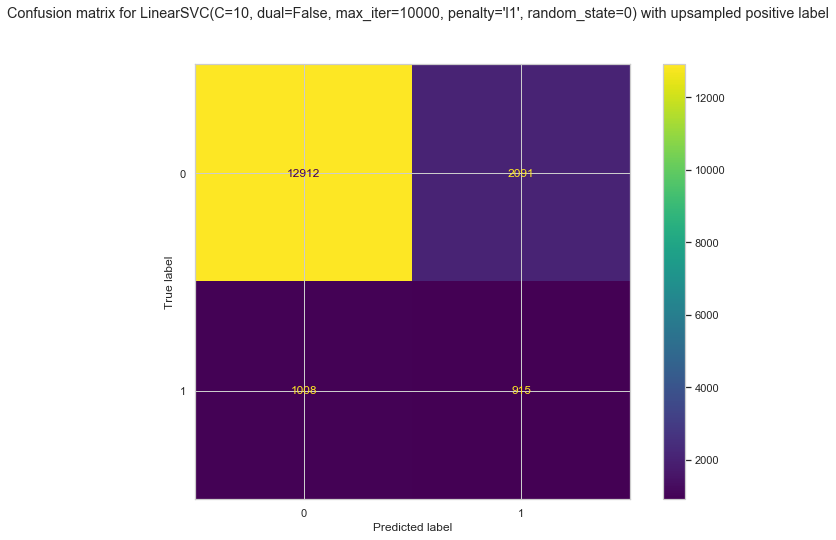

In [85]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
y_predicted = grid_search.best_estimator_.predict(X_test_NORM)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.suptitle('Confusion matrix for '+str(grid_search.best_estimator_)+' with upsampled positive label');
plot_confusion_matrix(grid_search.best_estimator_, X_test_NORM,y_test, ax=ax);

In [86]:
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(sklearn.metrics.accuracy_score(y_test, y_predicted),
                       sklearn.metrics.precision_score(y_test, y_predicted), 
                       sklearn.metrics.recall_score(y_test, y_predicted),
                       sklearn.metrics.f1_score(y_test, y_predicted)))

Accuracy: 0.8169088975540588
Precision: 0.30439121756487025
Recall: 0.47581903276131043
F1 Score: 0.37127206329884355


## Undersampling

In [87]:
undersample_negatives = resample(negatives,
                                 replace=True, # sample with replacement
                                 n_samples=len(positives), # match number in majority class
                                 random_state=0)
undersample_train_NORM = pd.concat([positives, undersample_negatives])

X_undersamp_train_NORM = undersample_train_NORM.loc[:, features]
y_undersamp_train = undersample_train_NORM.loc[:, 'muertos']

In [88]:
grid_search = GridSearchCV(estimator=LinearSVC(random_state=0, max_iter=10000, dual=False),
                           param_grid=paramgrid, cv=10,
                           return_train_score=True,
                           scoring=['accuracy', 'precision', 'recall'], 
                           refit='accuracy')
grid_search.fit(X_undersamp_train_NORM, y_undersamp_train)
cv_results_df = pd.DataFrame(grid_search.cv_results_)

#### Results when undersampling negative label

In [89]:
cols = ['params', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_test_precision',
        'rank_test_precision', 'mean_test_recall', 'rank_test_recall']
cv_results_df[cols].sort_values(by='rank_test_accuracy', ascending=True)

,params,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall
1,"{'C': 0.1, 'penalty': 'l2'}",0.719234,1,0.717548,2,0.723440,2
2,"{'C': 1, 'penalty': 'l1'}",0.719234,1,0.717607,1,0.723307,3
3,"{'C': 1, 'penalty': 'l2'}",0.719101,3,0.717412,3,0.723307,3
0,"{'C': 0.1, 'penalty': 'l1'}",0.719034,4,0.717117,8,0.723707,1
4,"{'C': 10, 'penalty': 'l1'}",0.718967,5,0.717340,4,0.723040,5
5,"{'C': 10, 'penalty': 'l2'}",0.718967,5,0.717340,4,0.723040,5
6,"{'C': 100, 'penalty': 'l1'}",0.718967,5,0.717340,4,0.723040,5
7,"{'C': 100, 'penalty': 'l2'}",0.718967,5,0.717340,4,0.723040,5


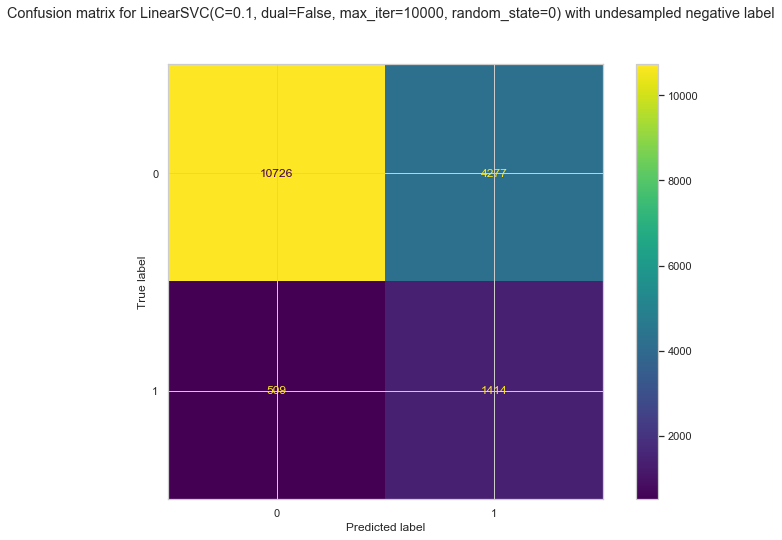

In [90]:
y_predicted = grid_search.best_estimator_.predict(X_test_NORM)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.suptitle('Confusion matrix for '+str(grid_search.best_estimator_)+' with undesampled negative label');
plot_confusion_matrix(grid_search.best_estimator_, X_test_NORM,y_test, ax=ax);

In [91]:
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(sklearn.metrics.accuracy_score(y_test, y_predicted),
                       sklearn.metrics.precision_score(y_test, y_predicted), 
                       sklearn.metrics.recall_score(y_test, y_predicted),
                       sklearn.metrics.f1_score(y_test, y_predicted)))

Accuracy: 0.717239749497814
Precision: 0.24846248462484624
Recall: 0.735309412376495
F1 Score: 0.37142106645652745


In [92]:
coeffs = pd.DataFrame.from_dict({'predictor':features,
                                 'coefficient':grid_search.best_estimator_.coef_.flatten(),
                                 'abs_coeffient':abs(grid_search.best_estimator_.coef_.flatten())})
coeffs.sort_values(by='abs_coeffient', inplace=True,ascending=False)

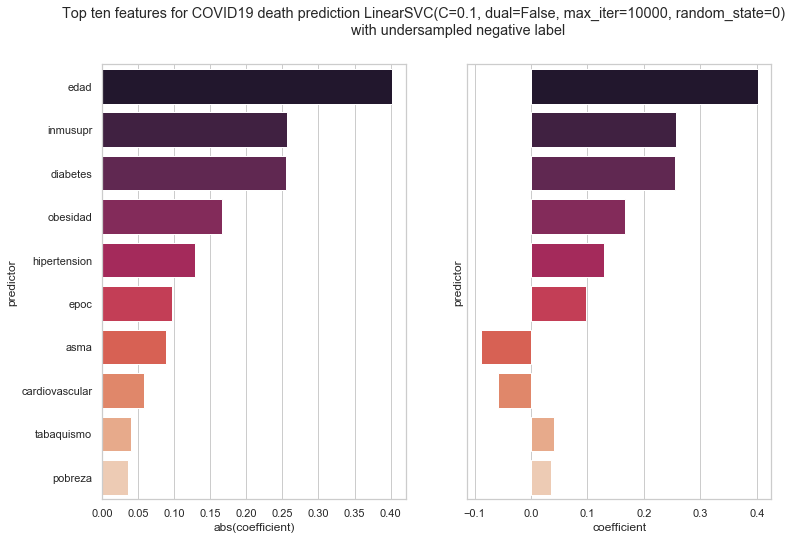

In [93]:
sns.set(style="whitegrid") 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 8)
plt.suptitle('''Top ten features for COVID19 death prediction {} 
                with undersampled negative label'''.format(grid_search.best_estimator_))

plt.sca(ax[0])
sns.barplot(x="abs_coeffient", y="predictor", data=coeffs[0:10],
            palette="rocket")
ax[0].set_xlabel('abs(coefficient)')

plt.sca(ax[1])
sns.barplot(x="coefficient", y="predictor", data=coeffs[0:10],
            palette="rocket")
plt.setp(ax[1],yticks=[]);

## Generate synthetic samples (Synthetic Minority Oversampling Technique)

SMOTE is a type of data augmentantion. This technique will create synthetic examples from the minority class (in our case the positive class --deaths--). The SMOTE technique uses a nearest neighbor algorithm on the training set to create synthetic examples of the undersampled class.

In [94]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [95]:
sm = SMOTE(random_state=0, ratio=1)
X_train_sm, y_train_sm = sm.fit_sample(train_NORM.loc[:, features], train_NORM.loc[:, 'muertos'])
X_train_sm = pd.DataFrame(X_train_sm)
X_train_sm.columns = features

C:\Users\robal\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [96]:
print('Original dataset shape %s' % Counter(train_NORM.loc[:, 'muertos']))
print('Resampled dataset shape %s' % Counter(y_train_sm))

Original dataset shape Counter({0: 60209, 1: 7492})
Resampled dataset shape Counter({0: 60209, 1: 60209})


In [97]:
grid_search = GridSearchCV(estimator=LinearSVC(random_state=0, max_iter=10000, dual=False),
                           param_grid=paramgrid, cv=10,
                           return_train_score=True,
                           scoring=['accuracy', 'precision', 'recall'], 
                           refit='accuracy')
grid_search.fit(X_undersamp_train_NORM, y_undersamp_train)
cv_results_df = pd.DataFrame(grid_search.cv_results_)

#### Results when generating synthetic samples from minority class using SMOTE.

In [98]:
cv_results_df[cols].sort_values(by='rank_test_accuracy', ascending=True)

,params,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall
1,"{'C': 0.1, 'penalty': 'l2'}",0.719234,1,0.717548,2,0.723440,2
2,"{'C': 1, 'penalty': 'l1'}",0.719234,1,0.717607,1,0.723307,3
3,"{'C': 1, 'penalty': 'l2'}",0.719101,3,0.717412,3,0.723307,3
0,"{'C': 0.1, 'penalty': 'l1'}",0.719034,4,0.717117,8,0.723707,1
4,"{'C': 10, 'penalty': 'l1'}",0.718967,5,0.717340,4,0.723040,5
5,"{'C': 10, 'penalty': 'l2'}",0.718967,5,0.717340,4,0.723040,5
6,"{'C': 100, 'penalty': 'l1'}",0.718967,5,0.717340,4,0.723040,5
7,"{'C': 100, 'penalty': 'l2'}",0.718967,5,0.717340,4,0.723040,5


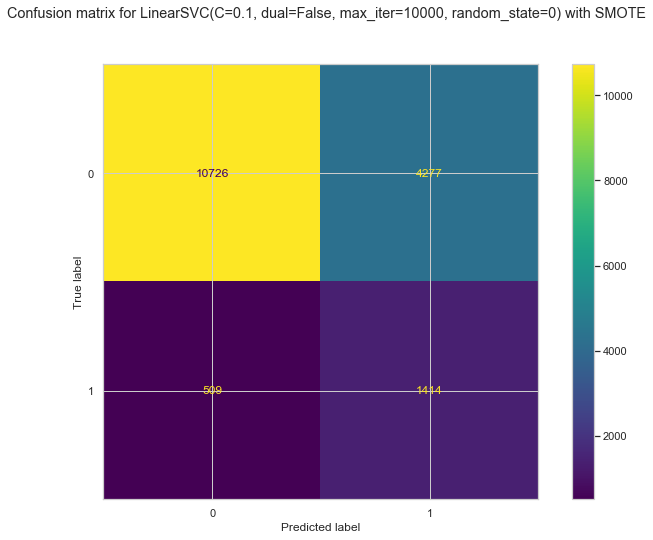

In [99]:
y_predicted = grid_search.best_estimator_.predict(X_test_NORM)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.suptitle('Confusion matrix for '+str(grid_search.best_estimator_)+' with SMOTE');
plot_confusion_matrix(grid_search.best_estimator_, X_test_NORM,y_test, ax=ax);

In [100]:
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(sklearn.metrics.accuracy_score(y_test, y_predicted),
                       sklearn.metrics.precision_score(y_test, y_predicted), 
                       sklearn.metrics.recall_score(y_test, y_predicted),
                       sklearn.metrics.f1_score(y_test, y_predicted)))

Accuracy: 0.717239749497814
Precision: 0.24846248462484624
Recall: 0.735309412376495
F1 Score: 0.37142106645652745


In [101]:
coeffs = pd.DataFrame.from_dict({'predictor':features,
                                 'coefficient':grid_search.best_estimator_.coef_.flatten(),
                                 'abs_coeffient':abs(grid_search.best_estimator_.coef_.flatten())})
coeffs.sort_values(by='abs_coeffient', inplace=True,ascending=False)

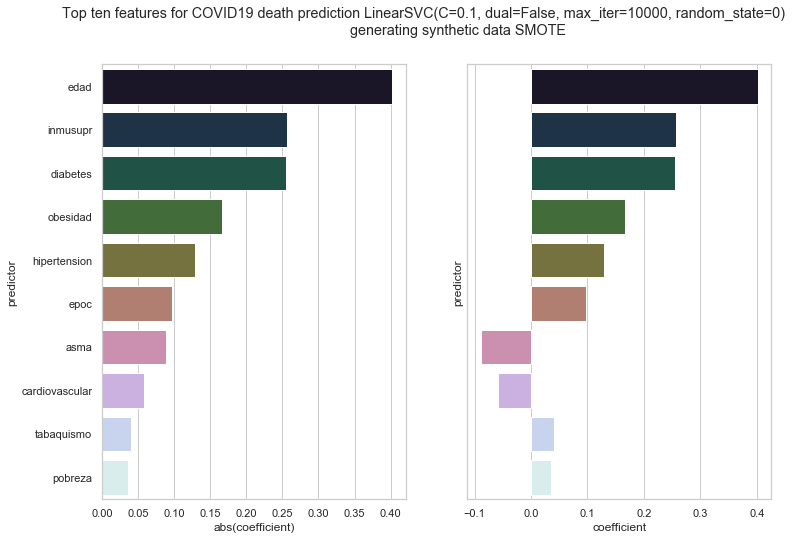

In [113]:
sns.set(style="whitegrid") 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 8)
plt.suptitle('''Top ten features for COVID19 death prediction {} 
                generating synthetic data SMOTE'''.format(grid_search.best_estimator_))

plt.sca(ax[0])
sns.barplot(x="abs_coeffient", y="predictor", data=coeffs[0:10],
            palette="cubehelix")
ax[0].set_xlabel('abs(coefficient)')

plt.sca(ax[1])
sns.barplot(x="coefficient", y="predictor", data=coeffs[0:10],
            palette="cubehelix")
plt.setp(ax[1],yticks=[]);

The past two SVM models trained (undersampling and using SMOTE) show similar feature importance. Not suprisingly age and comorbidities such as diabetes, immunosupression, obesity and hypertension are good predictors of whether or not COVID pacients will die. What is surprising is that the chronic lung disease asma while a good predictor it displays a negative relationship with covid mortality. That is people with asma tend to die at lower rates when infected that others. This result, while surprising, is not novel: https://www.nytimes.com/2020/04/16/health/coronavirus-asthma-risk.html

# Decision Trees

## Upsampling

In [110]:
from sklearn.tree import DecisionTreeClassifier
paramgrid = {'criterion':['gini','entropy'], 
             'max_depth':[1,3,5],
             'min_samples_split':[2,5,10]}
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=paramgrid, cv=10 ,
                             return_train_score=True,
                             scoring=['accuracy', 'precision', 'recall'], 
                             refit='accuracy')
grid_search_dt.fit(X_upsamp_train_NORM, y_upsamp_train)

C:\Users\robal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\robal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\robal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\robal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5],
                         'min_samples_split': [2, 5, 10]},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall'])

In [112]:
y_predicted = grid_search_dt.best_estimator_.predict(X_test_NORM)
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(sklearn.metrics.accuracy_score(y_test, y_predicted),
                       sklearn.metrics.precision_score(y_test, y_predicted), 
                       sklearn.metrics.recall_score(y_test, y_predicted),
                       sklearn.metrics.f1_score(y_test, y_predicted)))

Accuracy: 0.7939855843081649
Precision: 0.28409718387631144
Recall: 0.5351014040561622
F1 Score: 0.3711451758340848


## Undersampling

In [106]:
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=paramgrid, cv=10 ,
                             return_train_score=True,
                             scoring=['accuracy', 'precision', 'recall'], 
                             refit='accuracy')
grid_search_dt.fit(X_undersamp_train_NORM, y_undersamp_train)

In [107]:
y_predicted = grid_search_dt.best_estimator_.predict(X_test_NORM)
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(sklearn.metrics.accuracy_score(y_test, y_predicted),
                       sklearn.metrics.precision_score(y_test, y_predicted), 
                       sklearn.metrics.recall_score(y_test, y_predicted),
                       sklearn.metrics.f1_score(y_test, y_predicted)))

Accuracy: 0.65284178187404
Precision: 0.21824661439771917
Recall: 0.7961518460738429
F1 Score: 0.34258223316178116


## Generating synthetic samples (SMOTE)

In [108]:
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=paramgrid, cv=10 ,
                             return_train_score=True,
                             scoring=['accuracy', 'precision', 'recall'], 
                             refit='accuracy')
grid_search_dt.fit(X_train_sm, y_train_sm)
cv_results_df_dt = pd.DataFrame(grid_search.cv_results_)

In [109]:
y_predicted = grid_search_dt.best_estimator_.predict(X_test_NORM)
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(sklearn.metrics.accuracy_score(y_test, y_predicted),
                       sklearn.metrics.precision_score(y_test, y_predicted), 
                       sklearn.metrics.recall_score(y_test, y_predicted),
                       sklearn.metrics.f1_score(y_test, y_predicted)))

Accuracy: 0.6690889755405884
Precision: 0.2218693284936479
Recall: 0.7628705148205929
F1 Score: 0.3437609841827768


By using the same three methods for dealing with imbalanced data (upsampling, undersampling and SMOTE) we trained three decision trees above using cross validation. Compared to the support vector machine the decision trees perfomed much worse with all three models trained having very large trade off between precision and recall, and over all low f1-scores. Below we used the model with highest accuracy (DT using upsampling), to see what the most important predictors where.

In [119]:
grid_search_dt.best_estimator_.feature_importances_

array([0.84377956, 0.1044358 , 0.00365653, 0.        , 0.0036098 ,
       0.        , 0.        , 0.01353273, 0.        , 0.00792718,
       0.01605443, 0.00265633, 0.00434764])

Text(0.5, 0, 'Predictor importance')

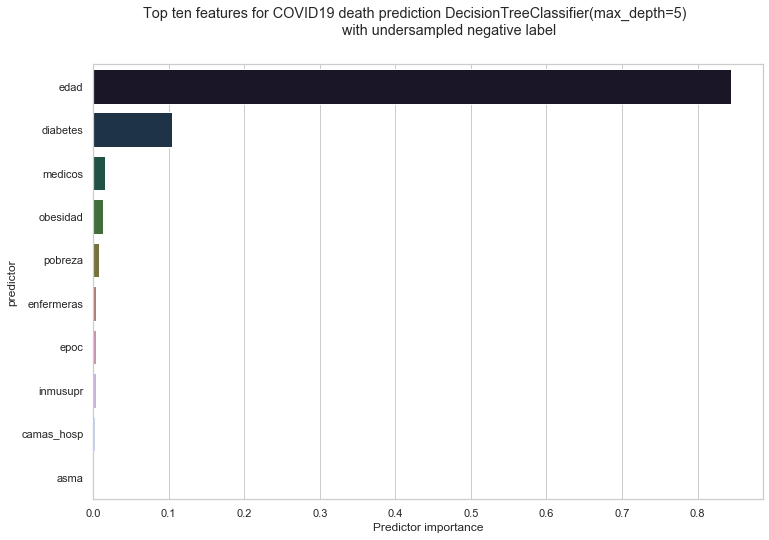

In [125]:
sns.set(style="whitegrid") 
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.suptitle('''Top ten features for COVID19 death prediction {} 
                with undersampled negative label'''.format(grid_search_dt.best_estimator_))
importance = pd.DataFrame.from_dict({'predictor':features,
                                     'importance':grid_search_dt.best_estimator_.feature_importances_.flatten()})

sns.barplot(x='importance', y='predictor', data=importance.sort_values(by="importance", ascending=False)[0:10],
            palette="cubehelix")
ax.set_xlabel('Predictor importance')
